In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
np.random.seed(42)

Generating Synthetic Data (10,000 rows; 2 Normal, 2 Uniform)

In [2]:
from numpy.random import default_rng
rng = default_rng(42)
n = 10_000

x1 = rng.normal(0, 1, n)
x2 = rng.normal(1.0, 2.0, n)

x3 = rng.uniform(-2.0, 2.0, n)
x4 = rng.uniform(0.0, 5.0, n)

x1_sq = x1**2
eps = rng.normal(0, 0.5, n)

beta_true = {"const": 1.25, "x1": 3.0, "x2": -2.0, "x3": 0.5, "x4": 1.5, "x1_sq": 0.8}

y = (beta_true["const"] + beta_true["x1"]*x1 + beta_true["x2"]*x2 + beta_true["x3"]*x3
     + beta_true["x4"]*x4 + beta_true["x1_sq"]*x1_sq + eps)

df = pd.DataFrame({"x1": x1, "x2": x2, "x3": x3, "x4": x4, "x1_sq": x1_sq, "y": y})
df.head()

,x1,x2,x3,x4,x1_sq,y
0,0.304717,1.352554,-0.548949,4.418454,0.092852,5.243261
1,-1.039984,2.798247,1.769626,4.954009,1.081567,1.554897
2,0.750451,-1.944541,-0.979191,2.430321,0.563177,11.244197
3,0.940565,0.429404,1.339845,2.300715,0.884662,8.061393
4,-1.951035,2.658307,1.587423,1.651558,3.806538,-3.413953


Test/Train Split (70/30)

In [3]:
features = ["x1", "x2", "x3", "x4", "x1_sq"]
X = df[features].copy()
y_all = df["y"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y_all, test_size=0.30, random_state=42)
X_train.shape, X_test.shape

((7000, 5), (3000, 5))

In [4]:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

ols_model = sm.OLS(y_train, X_train_sm).fit()
yhat_train = ols_model.predict(X_train_sm)
yhat_test = ols_model.predict(X_test_sm)

mse_train = mean_squared_error(y_train, yhat_train)
mse_test = mean_squared_error(y_test, yhat_test)

print(ols_model.summary())
print("\nTrain MSE:", round(mse_train, 4))
print("Test  MSE:", round(mse_test, 4))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 1.838e+05
Date:                Mon, 29 Sep 2025   Prob (F-statistic):               0.00
Time:                        17:54:23   Log-Likelihood:                -5011.3
No. Observations:                7000   AIC:                         1.003e+04
Df Residuals:                    6994   BIC:                         1.008e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2350      0.013     95.220      0.0

Residual Diagnostics (Train)

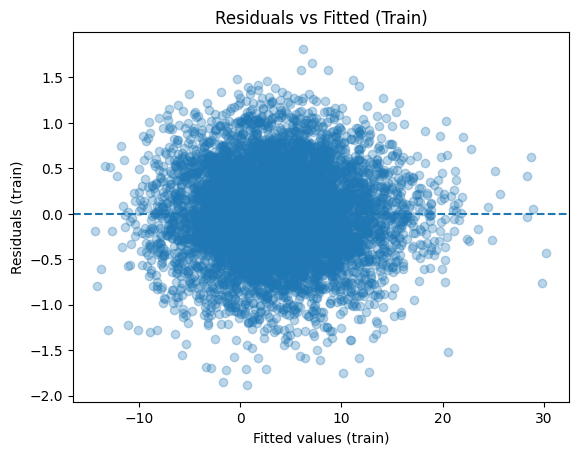

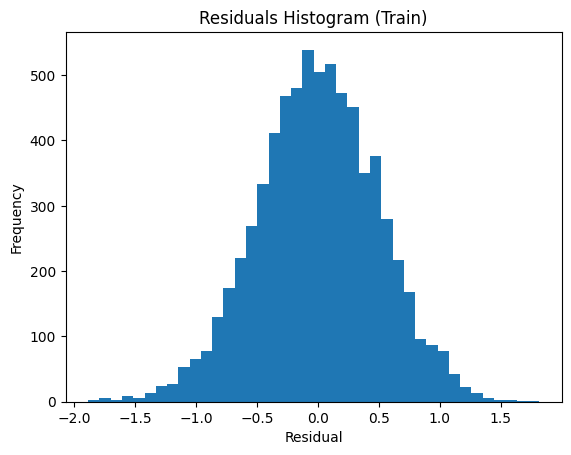

In [5]:
plt.figure()
plt.scatter(yhat_train, y_train - yhat_train, alpha=0.3)
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted values (train)")
plt.ylabel("Residuals (train)")
plt.title("Residuals vs Fitted (Train)")
plt.show()

plt.figure()
plt.hist(y_train - yhat_train, bins=40)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Residuals Histogram (Train)")
plt.show()

Bootstrap Resamples

In [6]:
B = 10
coef_list = []
for b in range(B):
    idx = rng.integers(0, len(df), size=len(df))
    X_b = sm.add_constant(df.loc[idx, features])
    y_b = df.loc[idx, "y"].values
    model_b = sm.OLS(y_b, X_b).fit()
    coef_list.append(model_b.params)

boot_coef_df = pd.DataFrame(coef_list)
boot_coef_df.index.name = "bootstrap_id"
boot_coef_df

,const,x1,x2,x3,x4,x1_sq
bootstrap_id,,,,,,
0,1.238453,3.004972,-1.999168,0.496049,1.498796,0.799935
1,1.250806,3.010784,-1.998513,0.501746,1.493371,0.797320
2,1.246945,3.017507,-2.000471,0.490291,1.499502,0.801949
3,1.242607,3.010155,-2.002845,0.498566,1.499145,0.796544
4,1.243390,3.007066,-1.998712,0.496476,1.500903,0.797399
5,1.225889,3.009045,-1.997850,0.493919,1.502913,0.801381
6,1.240057,3.005039,-1.999358,0.490408,1.499918,0.802831
7,1.242406,3.010692,-1.999028,0.493587,1.500302,0.801946
8,1.245045,3.005980,-1.997991,0.495144,1.502701,0.793687


In [7]:
param_stats = pd.DataFrame({"mean": boot_coef_df.mean(axis=0),
                            "std": boot_coef_df.std(axis=0, ddof=1)})
param_stats


,mean,std
const,1.241407,0.006655
x1,3.008229,0.004495
x2,-1.999564,0.001630
x3,0.494893,0.003542
x4,1.499430,0.002797
x1_sq,0.799504,0.003073


In [8]:
ols_params = ols_model.params.rename("train_OLS_coef")
comp = pd.concat([ols_params, param_stats], axis=1)
comp.round(4)

,train_OLS_coef,mean,std
const,1.2350,1.2414,0.0067
x1,3.0065,3.0082,0.0045
x2,-1.9987,-1.9996,0.0016
x3,0.4930,0.4949,0.0035
x4,1.5003,1.4994,0.0028
x1_sq,0.7970,0.7995,0.0031


With a correctly specified linear model (including the x1^2 term) and a large n=10,000, the OLS
coefficients are estimated very precisely. The bootstrap means are close to the train OLS point
estimates, and the bootstrap standard deviations are small, indicating low sampling variability.
Train and test MSE are very similar, consistent with low overfitting.